# Matched Distribution on resonance using a JSON import

- Start at resonance
- Add a quadrupole to move away from resonance
- Match a distribution
- Track and collapse quad over a few hundred turns
- You should see the ellipse transform into a triangular shape
- Then start SX

``dQ = Beta(at quad)*integrated_strength [m]*[m^-1]``


In [17]:
import xtrack as xt
import xpart as xp
import xobjects as xo

import pybt

import matplotlib.pyplot as plt

import json
from numpy import random
import random
import numpy as np

from cpymad.madx import Madx

import scipy as sp

# Constants

In [18]:
REL_GAMMA = 25.598474067
REL_BETA = np.sqrt(1-REL_GAMMA**(-2))

exn = 1.5e-6
eyn = 1.5e-6
ex = exn/(REL_BETA*REL_GAMMA)
ey = eyn/(REL_BETA*REL_GAMMA)

p = 24 # beam momentum (GeV/c)
momentum = 24 # beam momentum (GeV/c)
Brho = 24*3.3356

PS_radius = 70.079

TUNE_TARGET = 6.2

SEPTA = True

DPP_FACTOR = 1e-3

# Load PS at East Extraction

# Set PFWs, Cycle & Flatten

###
---

In [19]:
with open('ps_at_q_6_325.json') as f:
    line_dict = json.load(f)
line = xt.Line.from_dict(line_dict)
bare_line = xt.Line.from_dict(line_dict)

Done loading line from dict.           
Done loading line from dict.           


In [20]:
# Create monitors
ctx = xo.ContextCpu()

N_PART = int( 5e3 )
N_TURN = int( 5e2 )

line.particle_ref = xp.Particles(
    mass0=xp.PROTON_MASS_EV,
    q0=1,
    p0c=p*sp.constants.c
)

bare_line.particle_ref = xp.Particles(
    mass0=xp.PROTON_MASS_EV,
    q0=1,
    p0c=p*sp.constants.c
)

In [21]:
#[(i, x.to_dict()['__class__']) for i, x in enumerate(line.elements)]

In [22]:
tracker = bare_line.build_tracker()

generating ./edfadc82ba694b12b930aa491b0cacf9.c
the current directory is '/Users/ash/cern/dev/md9044/analysis/simulation'


In [23]:
tracker.twiss(method='4d')['qx']

6.325202595933513

In [24]:
#mad_tw = mad.twiss()
# TODO: check eps is normalised emittance

# particles = line.build_particles(method='4d',
#                                  x_norm = [1, 2, 3, 4],
#                                  nemmit_x = exn,
#                                  nemmit_y = eyn)

x_in_sigmas, px_in_sigmas = xp.generate_2D_gaussian(N_PART)

particles = bare_line.build_particles(method='4d',
                    x_norm=x_in_sigmas, # sigmas
                    px_norm=px_in_sigmas, # sigmas
                    nemitt_x=exn, nemitt_y=eyn)


In [25]:
cov = np.cov([particles.x, particles.px])
cov_px = np.cov(particles.px)

In [26]:
w3, h3, r3 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=3)
w2, h2, r2 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=2)
w1, h1, r1 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=1)

In [27]:
co = tracker.find_closed_orbit()
tw = tracker.twiss(method='4d')
parms =  pybt.tools.particles.get_parms(particles.x, particles.px)

Text(0, 0.5, 'px [rad]')

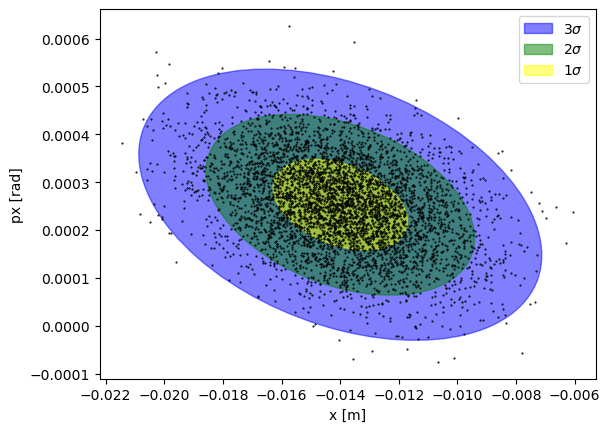

In [28]:
fig, ax = plt.subplots()
ax.plot(particles.x/1, particles.px/1, 'k.', markersize=1)
from matplotlib.patches import Ellipse
e3 = Ellipse(xy=(tw.x[0], tw.px[0]), width=w3, height=h3, angle=r3, color='blue', alpha=.5, label='3$\sigma$')
e2 = Ellipse(xy=(tw.x[0], tw.px[0]), width=w2, height=h2, angle=r2, color='green', alpha=.5, label='2$\sigma$')
e1 = Ellipse(xy=(tw.x[0], tw.px[0]), width=w1, height=h1, angle=r1, color='yellow', alpha=.5, label='1$\sigma$')

ax.add_artist(e3)
ax.add_artist(e2)
ax.add_artist(e1)
ax.plot()
ax.legend()

ax.set_xlabel('x [m]')
ax.set_ylabel('px [rad]')


In [29]:
DETUNE_QUAD_KNL1 = -0.01

In [30]:
detuning_quad = xt.SimpleThinQuadrupole(
    knl = [0, DETUNE_QUAD_KNL1]
)
line.insert_element(
    element = detuning_quad,
    index = 0,
    name = "DETUNING_QUAD"
)

In [31]:
smh57_monitor = xt.ParticlesMonitor(
    _context = ctx,
    num_particles = N_PART,
    start_at_turn = 0,
    stop_at_turn = N_TURN
)
smh61_monitor = xt.ParticlesMonitor(
    _context = ctx,
    num_particles = N_PART,
    start_at_turn = 0,
    stop_at_turn = N_TURN
)
line.insert_element(
    element = smh57_monitor,
    name = 'SMH57_MONITOR',
    index = 'pe.smh57'
)
line.insert_element(
    element = smh61_monitor,
    name = 'SMH61_MONITOR',
    index = 'pe.smh61'
)

# Perform MAD twiss
# mad_twiss = mad.twiss()
# mad_twiss_summ = mad_twiss.summary

tracker = line.build_tracker()

# Track
tunes = []
strengths = []
delta = line['DETUNING_QUAD'].knl[1]/N_TURN
for turn in range(N_TURN):
    cur_strength = line['DETUNING_QUAD'].knl[1]
    line['DETUNING_QUAD'].knl[1] = cur_strength - delta
    tracker.track(particles)
    tune = tracker.twiss(method='4d')['qx']
    tunes.append(tune)
    strengths.append(line['DETUNING_QUAD'].knl[1])

generating ./08683241e131480a986997d371b6f0c8.c
the current directory is '/Users/ash/cern/dev/md9044/analysis/simulation'


In [ ]:
tw = tracker.twiss(method='4d')
# print(f"Tune before detune: {mad_tw.summary['q1']}")
print(f"Tune after detune: {tw['qx']}")

Tune after detune: 6.298206973461096


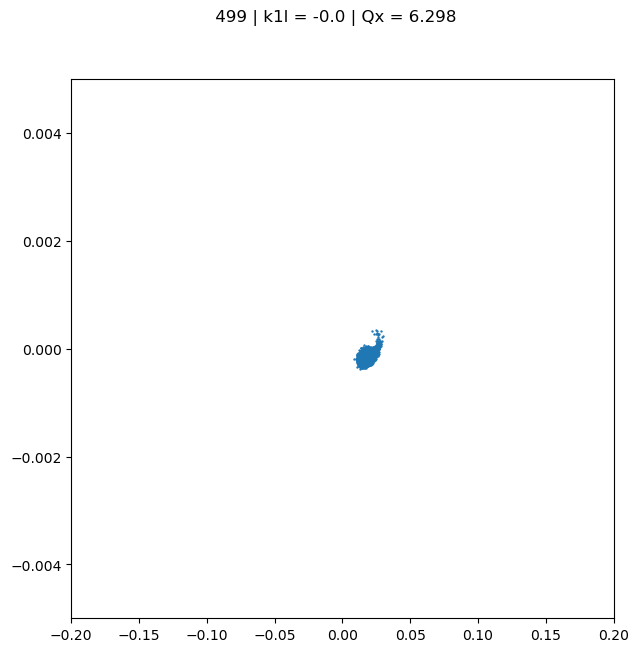

In [ ]:
from matplotlib.animation import FuncAnimation, PillowWriter

fig, ax = plt.subplots(figsize=(7, 7), tight_layout=False)

def animate(i):
    ax.clear()
    #ax.set_aspect("equal")
    ax.set_xlim(-0.2, 0.2)
    ax.set_ylim(-0.005, 0.005)
    fig.suptitle(f"{i:>4} | k1l = {round(strengths[i], 4):>4} | Qx = {round(tunes[i], 3):>4}")
    try:
        ax.scatter(smh57_monitor.x.T[i], smh57_monitor.px.T[i], marker='.', s=2)
    except:
        print("fail at", i)
        pass
    return
ani = FuncAnimation(fig, animate, interval=1, blit=False, repeat=False, frames=N_TURN)
ani.save("quad_collapse.gif", writer=PillowWriter(fps=30))


In [ ]:
1/tw['T_rev']

473128.56479373755